# Analyzing time series

While the Raven server specializes in hydrological modeling, the Finch server specializes in climate indicators, some of which are useful for stream flow series analysis. 

Here we'll test those indicators on a simple test file with around ten years of daily streamflow generated by a Raven simulation.

In [1]:
%matplotlib inline

from birdy import WPSClient
from ravenpy.utilities.testdata import get_file
import os
import xarray as xr

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("FINCH_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/finch/wps")
wps = WPSClient(url)
fn = str(get_file("hydro_simulations/raven-gr4j-cemaneige-sim_hmets-0_Hydrographs.nc"))

## Base flow index

The base flow index is the minimum 7-day average flow divided by the mean flow. 

In [2]:
help(wps.base_flow_index)

Help on method base_flow_index in module birdy.client.base:

base_flow_index(q=None, missing_options=None, check_missing='any', freq='YS', variable=None, output_formats=None) method of birdy.client.base.WPSClient instance
    Return the base flow index, defined as the minimum 7-day average flow divided by the mean flow.
    
    Parameters
    ----------
    q : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    freq : {'YS', 'MS', 'QS-DEC', 'AS-JUL'}string
        Resampling frequency; Defaults to "YS" (yearly).
    check_missing : {'any', 'wmo', 'pct', 'at_least_n', 'skip', 'from_context'}string
        Method used to determine which aggregations should be considered missing.
    missing_options : ComplexData:mimetype:`application/json`
        JSON representation of dictionary of missing method parameters.
    variable : string
        Name of the variable in the NetCDF file.
    
   

The base flow index needs as input arguments the link to a NetCDF file storing the stream flow time series, the name of the stream flow variable, and the frequency at which the index is computed (`YS`: yearly, `QS-DEC`: seasonally). 

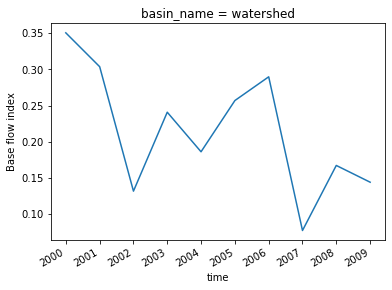

In [3]:
resp_bfi = wps.base_flow_index(fn, variable='q_sim')
out, log, meta = resp_bfi.get(asobj=True)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

out.base_flow_index.plot()

To compute generic statistics of a time series, use the `ts_stats` process.

In [4]:
help(wps.stats)

Help on method stats in module birdy.client.base:

stats(da=None, missing_options=None, check_missing='any', op='max', freq='YS', month=None, season=None, variable=None, output_formats=None) method of birdy.client.base.WPSClient instance
    Parameters
    ----------
    da : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    op : {'min', 'max', 'mean', 'std', 'var', 'count', 'sum', 'argmax', 'argmin'}string
        Reduce operation. Can either be a DataArray method or a function that can be applied to a DataArray.
    freq : {'YS', 'MS', 'QS-DEC', 'AS-JUL'}string
        Resampling frequency defining the periods defined in http://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling.
    month : {'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ...}integer
        Months of the year over which to compute indicator.
    season : {'DJF', 'MAM', 'JJA', 'SON'}string
        Clim

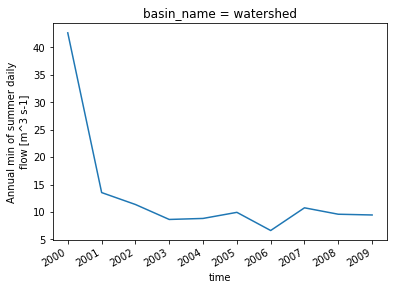

In [5]:
# Here we compute the annual summer (JJA) minimum
resp_stats = wps.stats(fn, variable='q_sim', op='min', season='JJA')
out, log, meta = resp_stats.get(asobj=True)
out.qsummermin.plot()

## Frequency analysis

The process `freq_analysis` is similar to the previous stat sin the it fits a series of annual maxima or minima to a statistical distribution, and returns the values corresponding to different return periods. 

In [6]:
help(wps.freq_analysis)

Help on method freq_analysis in module birdy.client.base:

freq_analysis(da, t=None, missing_options=None, check_missing='any', mode='max', dist='none', window=1, freq=None, month=None, season=None, variable=None, output_formats=None) method of birdy.client.base.WPSClient instance
    Parameters
    ----------
    da : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    mode : {'min', 'max'}string
        Whether we are looking for a probability of exceedance (high) or a probability of non-exceedance (low).
    t : integer
        Return period. The period depends on the resolution of the input data. If the input array's resolution is yearly, then the return period is in years.
    dist : string
        Name of the univariate distribution, such as beta, expon, genextreme, gamma, gumbel_r, lognorm, norm (see scipy.stats).
    window : integer
        Averaging window length (days).
    fre

For example, computing the Q27, the minimum 7-days streamflow of reccurrence two years, can be done using the following. 

In [7]:
resp_fa = wps.freq_analysis(fn, variable='q_sim', mode='min', t=2, dist='gumbel_r', window=7)

In [8]:
out, log, meta = resp_fa.get(asobj=True)
out.q7minannual

<xarray.DataArray 'q7minannual' (return_period: 1, nbasins: 1)>
array([[8.88304]])
Coordinates:
    basin_name     (nbasins) object ...
  * return_period  (return_period) int64 2
Dimensions without coordinates: nbasins
Attributes:
    units:               m^3 s-1
    original_long_name:  Simulated outflows
    long_name:           N-year return period min annual 7-day flow
    description:         Streamflow frequency analysis for the min annual 7-d...
    method:              ML
    estimator:           Maximum likelihood
    scipy_dist:          gumbel_r
    xclim_history:       [2021-01-27 20:37:41] q7minannual: freq_analysis(da=...
    cell_methods:        
    mode:                min
    standard_name:       discharge

An array of return periods can be passed. 

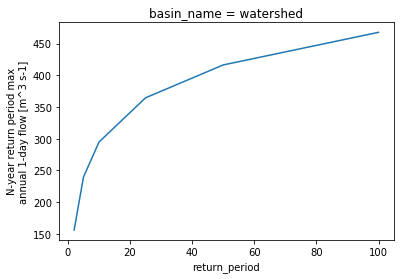

In [9]:
resp_fa2 = wps.freq_analysis(fn, variable='q_sim', mode='max', t=(2, 5, 10, 25, 50, 100), dist='gumbel_r')
out, log, meta = resp_fa2.get(asobj=True)
out.q1maxannual.plot()

## Getting the parameters of the distribution and comparing the fit

It's sometimes more useful to store the fitted parameters of the distribution rather than storing only the quantiles. In the example below, we're first computing the annual maxima of the simulated time series, then fitting them to a gumbel distribution using the `fit` process. 

In [10]:
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:     (nbasins: 1, time: 3654)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2010-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Data variables:
    precip      (time) float64 ...
    q_sim       (time, nbasins) float64 ...
    q_obs       (time, nbasins) float64 ...
    q_in        (time, nbasins) float64 ...
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output

In [11]:
import json
resp_stats2 = wps.stats(fn, variable="q_sim", op="max", check_missing="pct", missing_options=json.dumps({"pct": {"tolerance": .05}}))
ts = resp_stats2.get()[0]
print(ts)

http://localhost:5000/outputs/6eb5f75a-6109-11eb-8b6f-a44cc85b43bf/out.nc


In [12]:
da = resp_stats2.get(asobj=True)[0]
da.qannualmax.isel(nbasins=0)

<xarray.DataArray 'qannualmax' (time: 11)>
array([338.27671 , 142.897741, 225.275789, 145.49666 , 158.077381, 125.568246,
       104.491355, 206.672676, 176.020036, 191.896719,        nan])
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2010-01-01
    basin_name  object ...
Attributes:
    units:          m^3 s-1
    long_name:      Annual max of annual daily flow
    cell_methods:   
    xclim_history:  [2021-01-27 20:37:50] qannualmax: stats(da=<array>, op='m...
    standard_name:  discharge
    description:    Annual max of annual daily flow

In [13]:
resp = wps.fit(ts, dist='gumbel_r', check_missing="skip")
pa_fn = resp.get()[0]
pa = resp.get(True)[0]
pa.params

<xarray.DataArray 'params' (dparams: 2, nbasins: 1)>
array([[154.27106 ],
       [ 44.071605]])
Coordinates:
    basin_name  (nbasins) object ...
  * dparams     (dparams) object 'loc' 'scale'
Dimensions without coordinates: nbasins
Attributes:
    original_units:          m^3 s-1
    original_long_name:      Annual max of annual daily flow
    cell_methods:             time: fit
    xclim_history:           [2021-01-27 20:37:55] params: fit(da=<array>, di...
    original_standard_name:  discharge
    original_description:    Annual max of annual daily flow
    long_name:               Gumbel_r distribution parameters
    description:             Parameters of the gumbel_r distribution
    method:                  ML
    estimator:               Maximum likelihood
    scipy_dist:              gumbel_r
    units:                   
    standard_name:           gumbel_r parameters

To see how the distribution defined by those parameters compare with the original data, Raven's `graph_fit` process can help by creating a graphic showing an histogram of the data, overlayed with the fitted probability density function. The left y-axis displays the density (pdf) while the right y-axis displays the histogram count.  

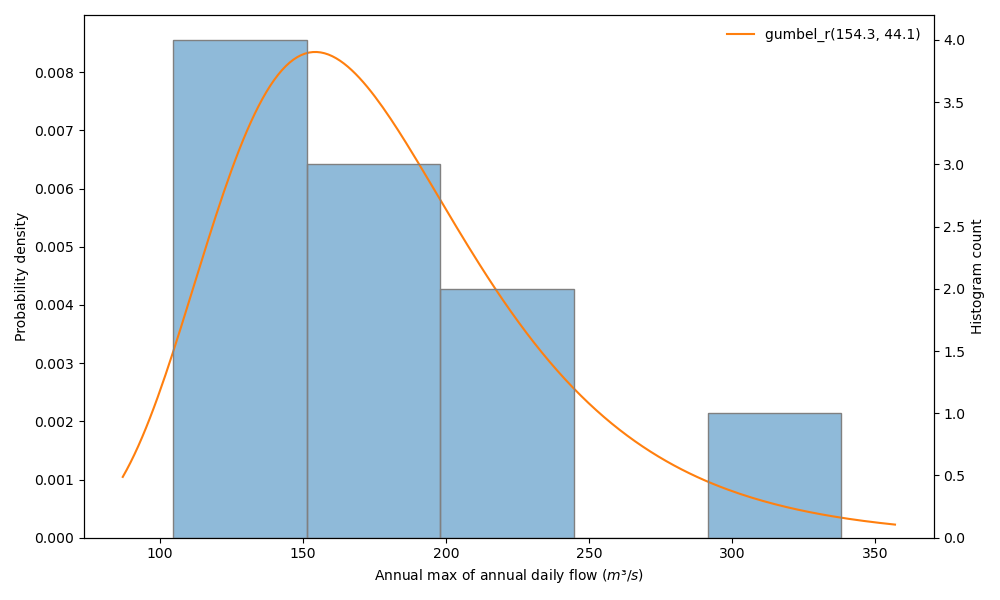

In [14]:
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
raven = WPSClient(url)

resp = raven.graph_fit(ts=ts, params=pa_fn)
resp.get(asobj=True)[0]